In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# Data Preparation

## Load Dataset & Initial Inspection

In [2]:
df = pd.read_csv("heart.csv")
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Unique values inpsection for non numeric cols

In [5]:
non_numeric_cols = df.select_dtypes(exclude=['number']).columns
print('Non-numeric columns:', list(non_numeric_cols))
for col in non_numeric_cols:
    unique_vals = df[col].unique()
    print(f"\n{col} ({len(unique_vals)} unique values): {unique_vals}")


Non-numeric columns: ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']

Sex (2 unique values): ['M' 'F']

ChestPainType (4 unique values): ['ATA' 'NAP' 'ASY' 'TA']

RestingECG (3 unique values): ['Normal' 'ST' 'LVH']

ExerciseAngina (2 unique values): ['N' 'Y']

ST_Slope (3 unique values): ['Up' 'Flat' 'Down']


## Cleaning

In [6]:
print("Missing Values:\n", df.isnull().sum())
print("\nJumlah Duplikasi:", df.duplicated().sum())

# Jika ada duplikasi → hapus
df.drop_duplicates(inplace=True)

Missing Values:
 Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

Jumlah Duplikasi: 0


## Encoding

In [7]:
categorical_binary = ['Sex', 'ExerciseAngina']
categorical_multiclass = ['ChestPainType', 'RestingECG', 'ST_Slope']

In [8]:
# Menyisakan dataframe sebelum encoding untuk kebutuhan visualisasi
plot_df = df[:]

In [9]:
# Label encoding untuk binary
# One-hot encoding untuk multi-class

# Binary to 0/1
for col in categorical_binary:
    df[col] = df[col].astype('category').cat.codes

# One-hot encoding
df = pd.get_dummies(df, columns=categorical_multiclass, drop_first=True)

df.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up
0,40,1,140,289,0,172,0,0.0,0,True,False,False,True,False,False,True
1,49,0,160,180,0,156,0,1.0,1,False,True,False,True,False,True,False
2,37,1,130,283,0,98,0,0.0,0,True,False,False,False,True,False,True
3,48,0,138,214,0,108,1,1.5,1,False,False,False,True,False,True,False
4,54,1,150,195,0,122,0,0.0,0,False,True,False,True,False,False,True


## Validation

In [10]:
# Deteksi nilai medis yang tidak masuk akal
print("RestingBP == 0 :", df[df['RestingBP'] == 0].shape[0])
print("Cholesterol == 0 :", df[df['Cholesterol'] == 0].shape[0])

RestingBP == 0 : 1
Cholesterol == 0 : 172


In [11]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Tangani nilai anomali dengan IterativeImputer (fit pada baris valid)
invalid_mask = (df['RestingBP'] == 0) | (df['Cholesterol'] == 0)
# Gunakan semua kolom (sudah numerik setelah encoding) untuk membantu imputasi
impute_cols = df.columns.tolist()

# Perform imputation
imputer = IterativeImputer(random_state=42)
imputer.fit(df.loc[~invalid_mask, impute_cols])

# Nullify invalid collumns for imputation
df.loc[invalid_mask, ['RestingBP', 'Cholesterol']] = np.nan
imputed = imputer.transform(df.loc[invalid_mask, impute_cols])

# Convert back to original dtypes to avoid pandas FutureWarning
imputed_df = pd.DataFrame(imputed, columns=impute_cols, index=df.index[invalid_mask])
for col in impute_cols:
    orig_dtype = df[col].dtype
    if pd.api.types.is_bool_dtype(orig_dtype):
        imputed_df[col] = imputed_df[col].round().clip(0, 1).astype(orig_dtype)
    elif pd.api.types.is_integer_dtype(orig_dtype):
        imputed_df[col] = imputed_df[col].round().astype(orig_dtype)
    else:
        imputed_df[col] = imputed_df[col].astype(orig_dtype, copy=False)

df.loc[invalid_mask, impute_cols] = imputed_df
# Also fix values in plot_df
plot_df.loc[invalid_mask, ['RestingBP', 'Cholesterol']] = imputed_df.loc[invalid_mask, ['RestingBP', 'Cholesterol']]

print(f"Imputed {invalid_mask.sum()} rows with IterativeImputer for RestingBP/Cholesterol")


Imputed 172 rows with IterativeImputer for RestingBP/Cholesterol


C:\Users\Muneki\AppData\Local\Temp\ipykernel_26800\1649487205.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[137.1790073  125.93431152 138.56419756 132.88098333 137.30899217
 132.13082876 133.6148513  135.81678854 132.99453148 134.83012985
 139.53872114 134.66397644 134.4217645  133.45326675 132.99302058
 135.44018837 135.02683305 137.22010857 135.88907113 129.93349787
 125.58494465 134.37393086 143.43701822 134.28646075 136.91640094
 139.23394289 140.9779952  137.76696106 135.60951102 130.17651672
 140.07773429 127.26455248 127.28747625 127.8846575  136.98451811
 134.11932936 138.10179608 138.31388006 133.67766509 123.66600227
 128.2983984  131.02563712 135.64244515 140.57189023 141.8317597
 139.28593343 138.34626964 130.89179156 139.45203955 137.65891604
 132.35911052 132.06099034 137.98265993 134.1575773  130.74759931
 141.22224122 127.85754082 132.75034858 129.69274466 133.13525506
 136.197077

# Exploratory Data Analysis (EDA)

In [12]:
print("Shape:", df.shape)

Shape: (918, 16)


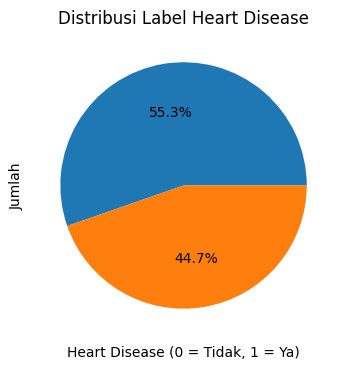

In [13]:
# Distribusi Target (Heart Disease)
plt.figure(figsize=(6,4))
plt.pie(x=df['HeartDisease'].value_counts(), autopct="%0.1f%%")
plt.title("Distribusi Label Heart Disease")
plt.xlabel("Heart Disease (0 = Tidak, 1 = Ya)")
plt.ylabel("Jumlah")
plt.show()

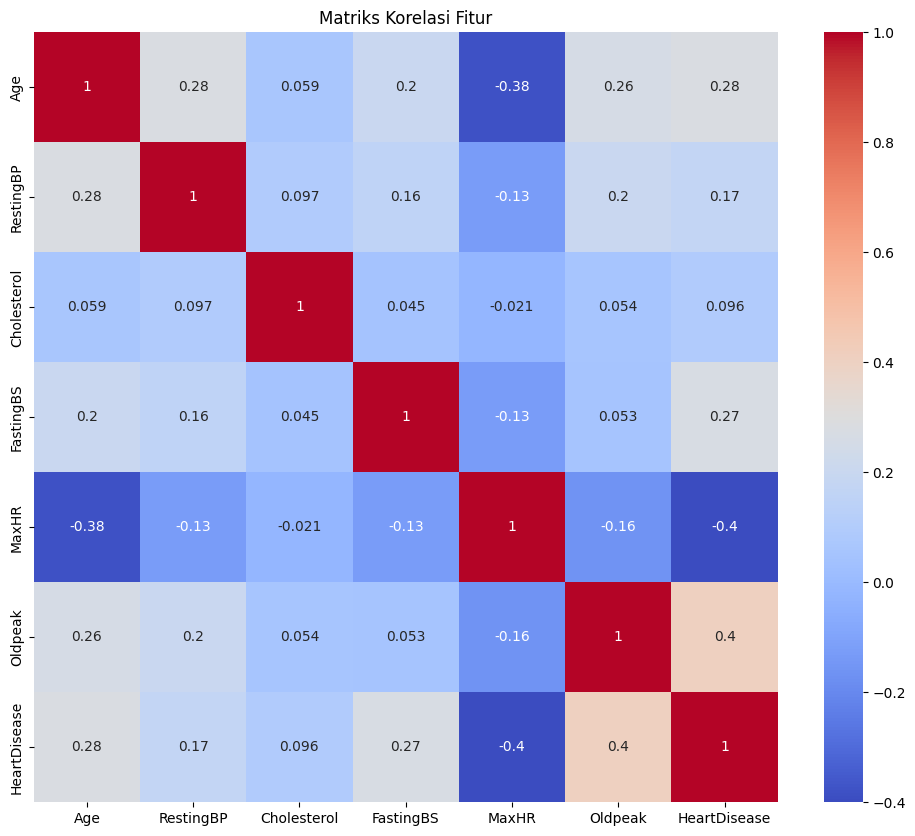

In [14]:
# Korelasi antar fitur numerik
plt.figure(figsize=(12,10))
correlation_matrix = plot_df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriks Korelasi Fitur")
plt.show()

# Data Visualization

Visualisasi menggunakan dataframe sebelum kategorisasi untuk mempermudahkan

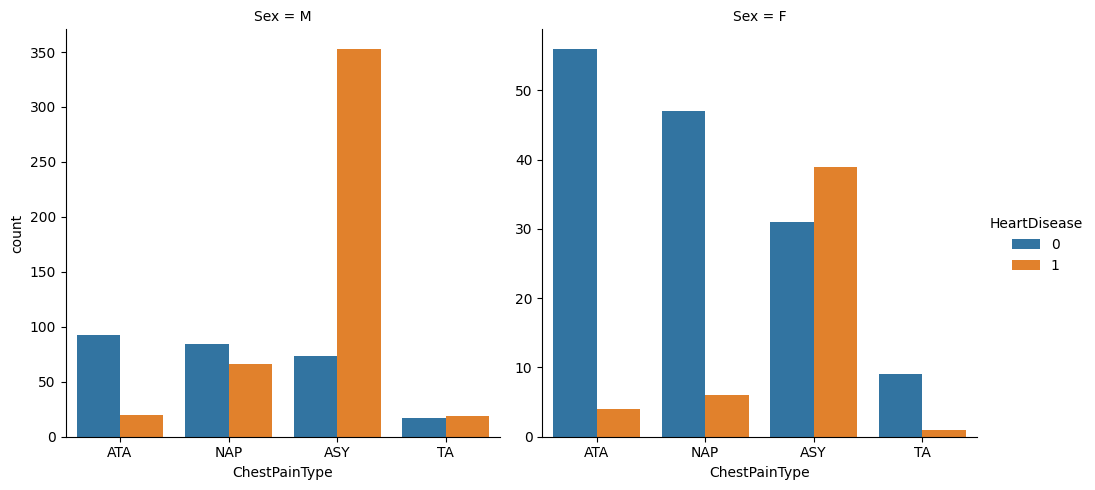

In [15]:
# Visualisasi 1 - ChestPainType vs HeartDisease
sns.catplot(data=plot_df, x='ChestPainType', hue='HeartDisease', kind='count', col='Sex', sharey=False)

plt.show()



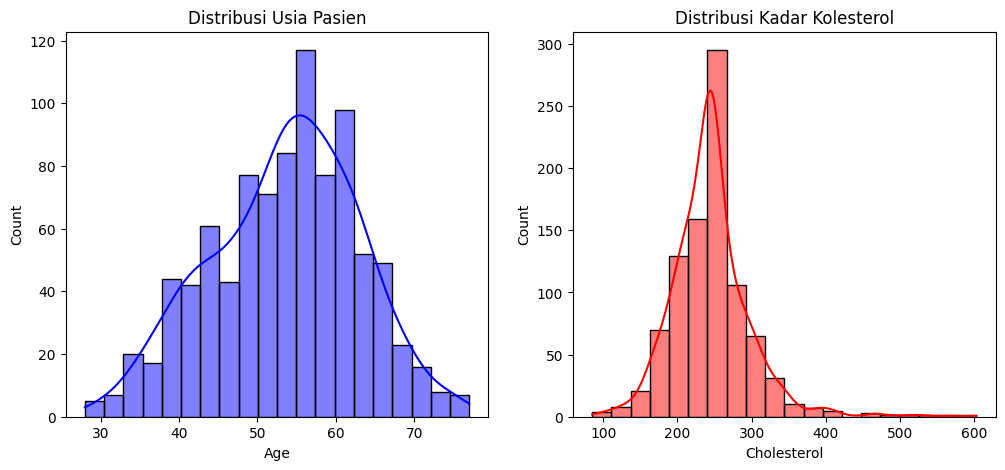

In [16]:
# Visualisasi 2 - Distribusi Age dan Cholesterol
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(plot_df['Age'], kde=True, bins=20, color='blue')
plt.title("Distribusi Usia Pasien")

plt.subplot(1,2,2)
sns.histplot(plot_df['Cholesterol'], kde=True, bins=20, color='red')
plt.title("Distribusi Kadar Kolesterol")
plt.show()

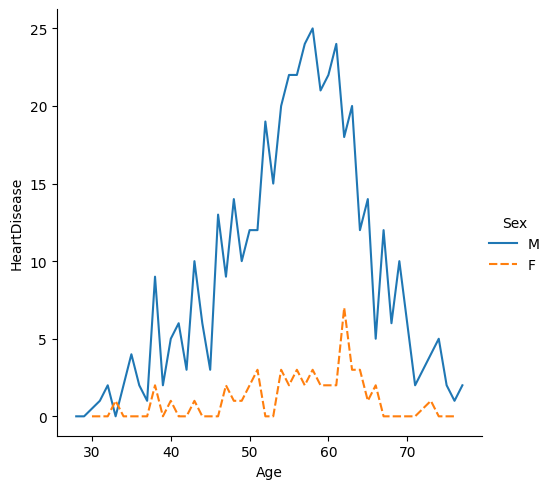

In [17]:
# Visualisasi 3 - 

grouped_df = plot_df.groupby(['Age', 'Sex'], as_index=False)['HeartDisease'].sum()
sns.relplot(
    data=grouped_df,
    x="Age", y="HeartDisease", hue="Sex", style="Sex", kind="line"
)
plt.show()

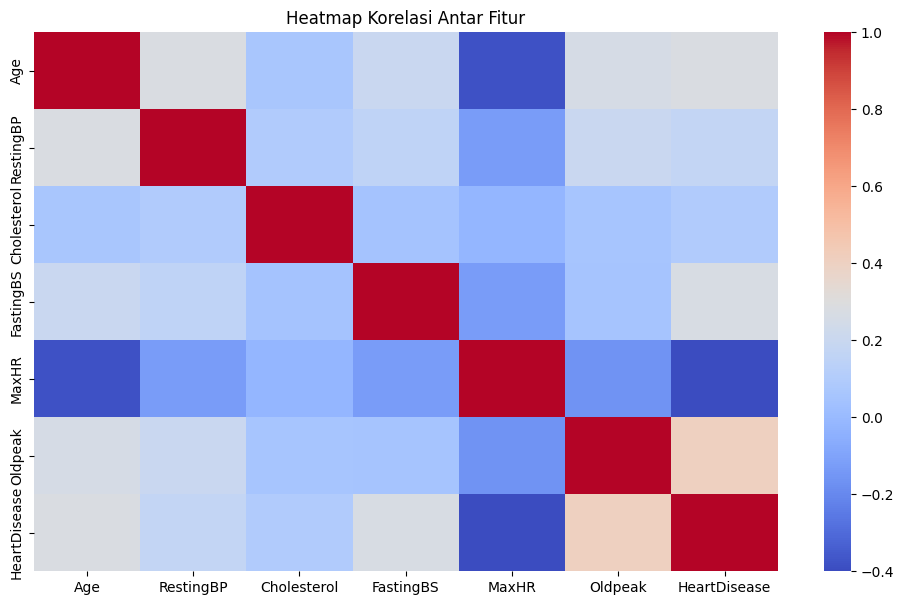

In [18]:
# Visualisasi 4 - Semua Fitur Numerik
plt.figure(figsize=(12,7))
sns.heatmap(plot_df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Heatmap Korelasi Antar Fitur")
plt.show()

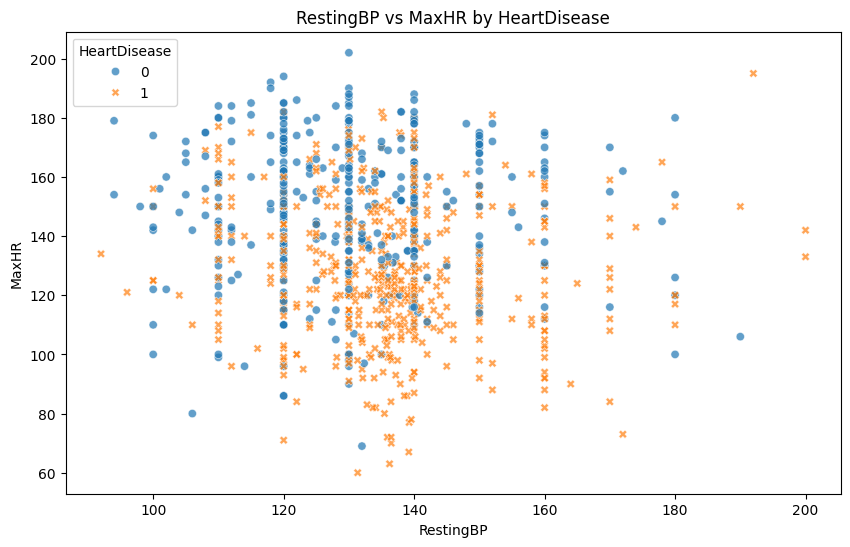

In [19]:
# Visualisasi 5 - RestingBP vs MaxHR dengan HeartDisease sebagai hue
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=plot_df,
    x='RestingBP',
    y='MaxHR',
    hue='HeartDisease',
    style='HeartDisease',
    # palette='coolwarm',
    alpha=0.7
)
plt.title("RestingBP vs MaxHR by HeartDisease")
plt.show()

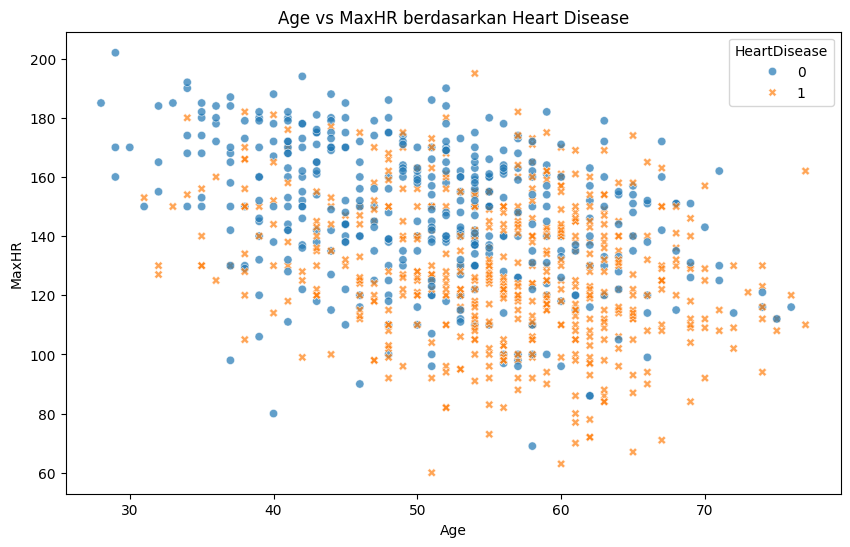

In [20]:
# Visual 6 - Hubungan Age vs MaxHR Based on Target Label
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='Age', y='MaxHR', hue='HeartDisease', alpha=0.7, style='HeartDisease',)
plt.title("Age vs MaxHR berdasarkan Heart Disease")
plt.show()

# Model Machine Learning

In [21]:
# Target dan fitur
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (918, 15)
y shape: (918,)


In [22]:
y.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

In [23]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=41,
    stratify=y   # menjaga proporsi kelas
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

Train size: 734
Test size : 184


In [24]:
y_test.value_counts()

HeartDisease
1    102
0     82
Name: count, dtype: int64

In [25]:
# Scaling Fitur Numerik
scaler = StandardScaler()

# Fit di train, transform train & test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

## Logistic Regression

In [26]:
logreg = LogisticRegression(max_iter=1000, random_state=41)
logreg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=41)

In [27]:
# Evaluasi Akurasi
# Prediksi
y_pred = logreg.predict(X_test_scaled)

# Akurasi
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy (Logistic Regression): {acc:.4f}")

Accuracy (Logistic Regression): 0.8967


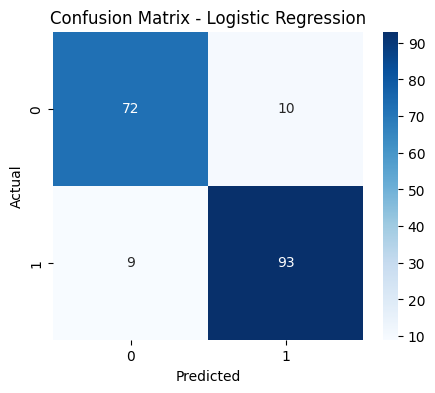


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [28]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

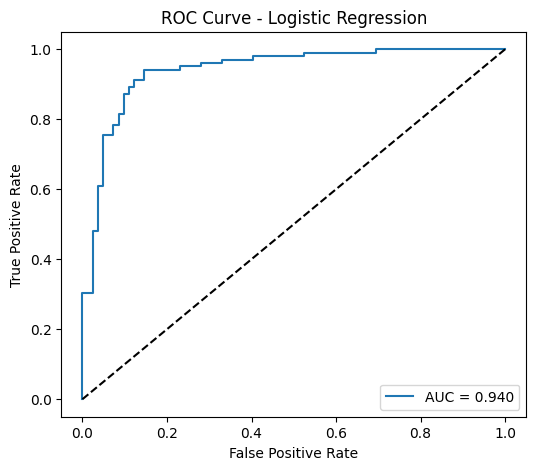

In [29]:
# Probabilitas kelas positif
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]

# Hitung ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')  # garis random
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.show()

## Random Forest

In [30]:
# Model Random Forest
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=41,
    class_weight="balanced"  # lebih sensitif pada kelas minoritas
)

rf.fit(X_train, y_train)

# Prediksi
y_pred_rf = rf.predict(X_test)

# Evaluasi
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy (Random Forest): {acc_rf:.4f}")

Accuracy (Random Forest): 0.8967


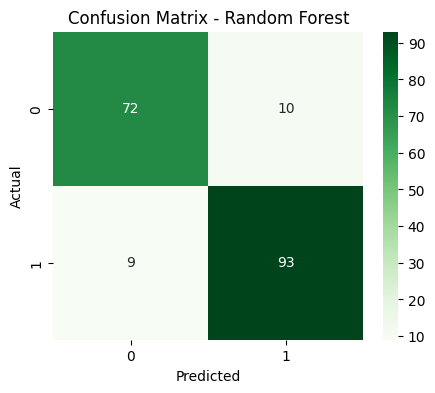


Classification Report - Random Forest
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [31]:
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report - Random Forest")
print(classification_report(y_test, y_pred_rf))

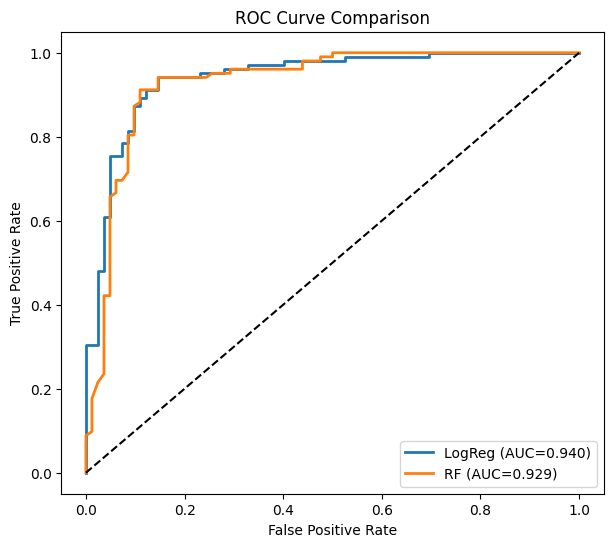

In [32]:
y_proba_rf = rf.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

plt.figure(figsize=(7,6))

# Logistic Regression (dari kode sebelumnya)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg (AUC={roc_auc:.3f})", linewidth=2)

# Random Forest
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={roc_auc_rf:.3f})", linewidth=2)

plt.plot([0,1], [0,1], "k--")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## XGBoost

In [33]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=41,
    eval_metric='logloss'
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy (XGBoost): {acc_xgb:.4f}")

Accuracy (XGBoost): 0.9022


In [34]:
print("\nClassification Report - XGBoost")
print(classification_report(y_test, y_pred_xgb))


Classification Report - XGBoost
              precision    recall  f1-score   support

           0       0.88      0.90      0.89        82
           1       0.92      0.90      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [35]:
y_proba_xgb = xgb.predict_proba(X_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
print(f"AUC (XGBoost): {roc_auc_xgb:.4f}")

AUC (XGBoost): 0.9407


## SVM

In [36]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', probability=True, random_state=41)
svm.fit(X_train_scaled, y_train)

y_pred_svm = svm.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"Accuracy (SVM): {acc_svm:.4f}")

print("\nClassification Report - SVM")
print(classification_report(y_test, y_pred_svm))

Accuracy (SVM): 0.9022

Classification Report - SVM
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        82
           1       0.91      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [37]:
print("\nClassification Report - SVM")
print(classification_report(y_test, y_pred_svm))


Classification Report - SVM
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        82
           1       0.91      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



In [38]:
y_proba_svm = svm.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
print(f"AUC (SVM): {roc_auc_svm:.4f}")

AUC (SVM): 0.9423


## KNN

In [39]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train_scaled, y_train)

y_pred_knn = knn.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy (KNN): {acc_knn:.4f}")

print("\nClassification Report - KNN")
print(classification_report(y_test, y_pred_knn))

Accuracy (KNN): 0.8967

Classification Report - KNN
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [40]:
print("\nClassification Report - KNN")
print(classification_report(y_test, y_pred_knn))


Classification Report - KNN
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



In [41]:
y_proba_knn = knn.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
print(f"AUC (KNN): {roc_auc_knn:.4f}")

AUC (KNN): 0.9244


# Perbandingan Akurasi Model

In [42]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost", "SVM", "KNN"],
    "Accuracy": [acc, acc_rf, acc_xgb, acc_svm, acc_knn],
    "AUC": [roc_auc, roc_auc_rf, roc_auc_xgb, roc_auc_svm, roc_auc_knn]
})

comparison

,Model,Accuracy,AUC
0,Logistic Regression,0.896739,0.940459
1,Random Forest,0.896739,0.929220
2,XGBoost,0.902174,0.940698
3,SVM,0.902174,0.942253
4,KNN,0.896739,0.924378
